In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

from pycbc import conversions
from pycbc import detector
from pycbc.inference import io,models

In [3]:
def remove_space(df):
    df.columns = [c.replace(' ','') for c in df.columns]
    return df

def readlnb(path):
    d221 = pd.read_csv(path + "/221/GW150914_PROD1_Kerr_221_0M/Nested_sampler/Evidence.txt",sep=' ')
    d220 = pd.read_csv(path + "/220/GW150914_PROD1_Kerr_220_0M/Nested_sampler/Evidence.txt",sep=' ')
    d221 = remove_space(d221)
    d220 = remove_space(d220)
    return d221['lnB'].values[0] - d220['lnB'].values[0]

def readsnr(path):
    d221 = pd.read_csv(path + "/221/GW150914_PROD1_Kerr_221_0M/Nested_sampler/Evidence.txt",sep=' ')
    d220 = pd.read_csv(path + "/220/GW150914_PROD1_Kerr_220_0M/Nested_sampler/Evidence.txt",sep=' ')
    d221 = remove_space(d221)
    d220 = remove_space(d220)
    return d221['Estimated_SNR'].values[0], d220['Estimated_SNR'].values[0]

def readlnz_signalnoise(path):
    d221 = pd.read_csv(path + "/221/GW150914_PROD1_Kerr_221_0M/Nested_sampler/Evidence.txt",sep=' ')
    d220 = pd.read_csv(path + "/220/GW150914_PROD1_Kerr_220_0M/Nested_sampler/Evidence.txt",sep=' ')
    d221 = remove_space(d221)
    d220 = remove_space(d220)
    return d221['lnZ_signal'].values[0], d221['lnZ_noise'].values[0], d220['lnZ_signal'].values[0], d220['lnZ_noise'].values[0]

In [4]:
def lnb(filename):
	f = h5py.File(filename,'r')
	return f.attrs['log_evidence'] 

def pycbc_snr(filename):
    fp = io.loadfile(filename, 'r')
    # get the config, the data, and PSDs from the file
    # the config file:
    cp = fp.read_config_file()
    # the data
    data = fp.read_data()
    # the psds
    psds = fp.read_psds()
    model = models.read_from_config(cp, data=data, psds=psds)
    samples = fp.read_samples(list(fp['samples'].keys()))
    maxlidx = samples['loglikelihood'].argmax()
    maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}
    model.update(**maxlparams)
    model.loglikelihood
    return (2*model.loglr)**0.5

fixpsd = '/work/yifan.wang/ringdown/GW150914/pyring/r5-fixpsd-increase-flow/'
unfixpsd = '/work/yifan.wang/ringdown/GW150914/pyring/r6-dontfixpsd/'

def print_lnb_snr(path):
    dt = np.linspace(-1.46, 1.47, 13)
    t0 = 1126259462.4085495
    t = t0+dt/1000
    result = {}
    snr221 = {}
    snr220 = {}
    for i in range(13):
        print(i)
        f220 = path+'t'+str(i)+'/220/result.hdf'
        f221 = path+'t'+str(i)+'/221/result.hdf'
        try:
            result[t[i]] = lnb(f221) - lnb(f220)
        except FileNotFoundError:
            pass
        
        try:
            snr221[t[i]] = pycbc_snr(f221)
        except IOError:
            pass
        
        try:
            snr220[t[i]] = pycbc_snr(f220)
        except IOError:
            pass
    return result,snr221,snr220

# Reproducing PyRing Results

In [5]:
rootpath = '/work/yifan.wang/ringdown/GW150914/pyring/re-pyring-t0p2/'
time = np.linspace(-1.46,1.47,13)
pyring_lnb = {}
pyring_snr221 = {}
pyring_snr220 = {}

for i,t in enumerate(time):
    path = rootpath + '/t'+str(i)
    try:
        pyring_lnb[i] = readlnb(path)
        pyring_snr221[i],pyring_snr220[i] = readsnr(path)
    except FileNotFoundError:
        pass

In [6]:
rootpath = '/work/yifan.wang/ringdown/GW150914/pyring/reproduce/'
time = np.linspace(-1.46,1.47,13)
pyring_lnb_t0p1 = {}
pyring_snr221_t0p1 = {}
pyring_snr220_t0p1 = {}

for i,t in enumerate(time):
    path = rootpath + '/t'+str(i)
    try:
        pyring_lnb_t0p1[i] = readlnb(path)
        pyring_snr221_t0p1[i],pyring_snr220_t0p1[i] = readsnr(path)
    except FileNotFoundError:
        pass

In [7]:
pyring_lnb

{0: 15.141998818216962,
 1: 8.081229125382379,
 2: 3.9904803952522414,
 3: 1.3698683071124833,
 4: 5.046913898695493,
 5: -0.9517198539106104,
 6: 0.6706983997282805,
 7: -0.17280608096916694,
 8: -0.4866939352359587,
 9: -0.9338803448335966,
 10: -0.5936119510151894,
 11: -0.5601800050935708,
 12: -2.281902236165479}

In [11]:
import lal
tM = 69 * lal.MTSUN_SI
t0rd = 1126259462.423
t0pr = t0rd + 0.00023
rd = np.loadtxt('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/mi-B.csv',delimiter=",")

Text(0.5, 1.0, 'Bayesian Evidence of 221 vs 220')

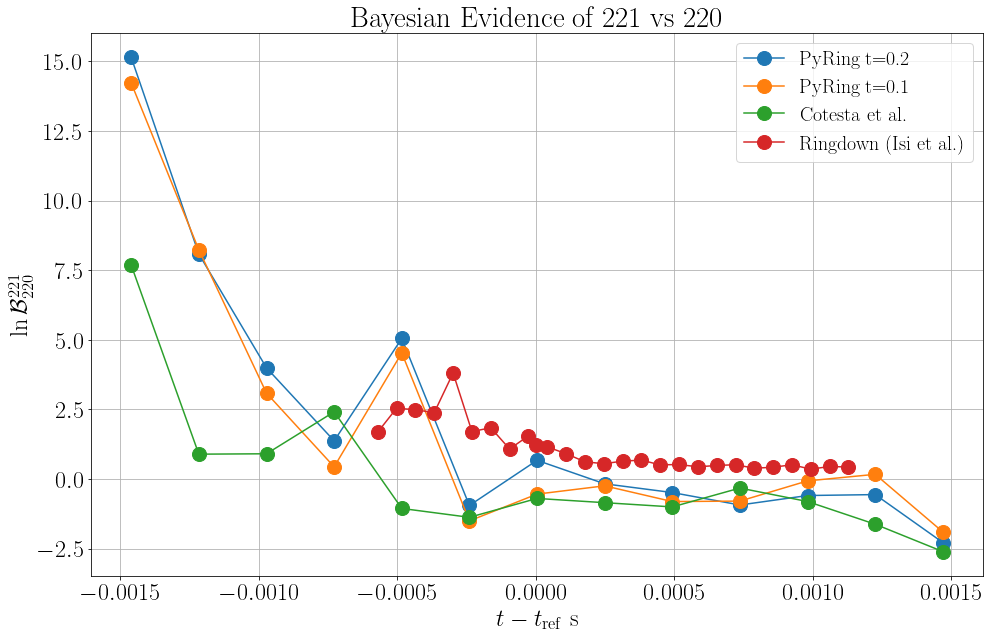

In [13]:
dt = np.linspace(-1.46, 1.47, 13)
t0 = 1126259462.4085495
t = t0+dt/1000

plt.figure(figsize=[16,10])

x,y = zip(*pyring_lnb.items())
x = np.array(x)
plt.plot(t[x]-t0,y,marker='o',label='PyRing t=0.2')

x,y = zip(*pyring_lnb_t0p1.items())
x = np.array(x)
plt.plot(t[x]-t0,y,marker='o',label='PyRing t=0.1')


filec = np.loadtxt('/work/yifan.wang/pax/figs-comdiffruns/cotesta-B.txt')
plt.plot(t-t0,np.log(filec[:,1]),marker='o',label='Cotesta et al.')
#plt.axvline(1126259462.4085495,ls='--',label='t0')



##############Ringdown###########################
#ringdown. 0 corresponds to 1126259462.42323
plt.plot(rd[:,0]*tM-0.00023,np.log10(rd[:,1]),marker='o',label='Ringdown (Isi et al.)')
#

plt.legend()
plt.ylabel('$\ln \mathcal{B}^{221}_{220}$')
plt.xlabel('$t-t_\mathrm{ref}$ s')
plt.title('Bayesian Evidence of 221 vs 220')